In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
from src.data.dataset import load_dataset_and_build_features

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
figure_width = 15 # "inches"
fig_path = 'reports/figures/'

In [2]:
df = load_dataset_and_build_features()
df.head()

timestamp   
seq_guid                                           date                                   
53a85331e431960200466a39|140fae5cfea3485ab5c6d7... 2018-03-05  2018-03-05T00:00:00.000Z  \
                                                   2018-04-11  2018-04-11T00:00:00.000Z   
                                                   2018-04-25  2018-04-25T00:00:00.000Z   
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd... 2018-01-26  2018-01-26T00:00:00.000Z   
53a85378e431960200469d42|ff242a09ec5b7f16a49413... 2017-10-02  2017-10-02T00:00:00.000Z   

                                                               value   
seq_guid                                           date                
53a85331e431960200466a39|140fae5cfea3485ab5c6d7... 2018-03-05  25000  \
                                                   2018-04-11  25600   
                                                   2018-04-25  25000   
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd... 2018-01-26  12100   
53a85378e431960200469d42|ff242a09ec5b7f16a49413... 2017-10-02    600   

                                                               day_of_week   
seq_guid                                           date                      
53a85331e431960200466a39|140fae5cfea3485ab5c6d7... 2018-03-05            0  \
                                                   2018-04-11            2   
                                                   2018-04-25            2   
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd... 2018-01-26            4   
53a85378e431960200469d42|ff242a09ec5b7f16a49413... 2017-10-02            0   

                                                               weekend   
seq_guid                                           date                  
53a85331e431960200466a39|140fae5cfea3485ab5c6d7... 2018-03-05        0  \
                                                   2018-04-11        0   
                                                   2018-04-25        0   
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd... 2018-01-26        0   
53a85378e431960200469d42|ff242a09ec5b7f16a49413... 2017-10-02        0   

                                                               fed_holiday  
seq_guid                                           date                     
53a85331e431960200466a39|140fae5cfea3485ab5c6d7... 2018-03-05            0  
                                                   2018-04-11            0  
                                                   2018-04-25            0  
53a85378e431960200469d42|76f7222aa18d6b39a7ebdd... 2018-01-26            0  
53a85378e431960200469d42|ff242a09ec5b7f16a49413... 2017-10-02            0

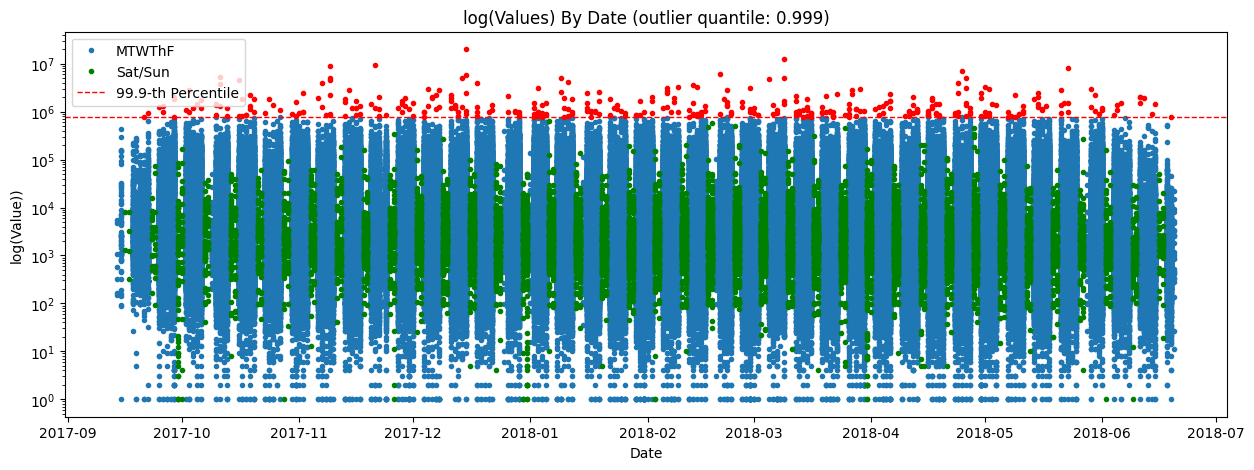

In [3]:
outlier_threshold = 0.999
_df = df[df.value < df.value.quantile(outlier_threshold)]
outliers = df[df.value >= df.value.quantile(outlier_threshold)]
weekends = _df.loc[df.weekend == 1]
weekdays = _df.loc[df.weekend == 0]

fig, ax = plt.subplots(figsize=(figure_width,5))
ax.set_yscale('log')
plt.title(f"log(Values) By Date (outlier quantile: {outlier_threshold})")
plt.xlabel("Date")
plt.ylabel("log(Value))")

ax.plot(weekdays.reset_index().date, weekdays.value,
        marker='.', linestyle='', label='MTWThF')
ax.plot(weekends.reset_index().date, weekends.value,
        marker='.', linestyle='',
        c='green', label='Sat/Sun')
ax.plot(outliers.reset_index().date, outliers.value,
        marker='.', linestyle='', c='r')

plt.axhline(df.value.quantile(outlier_threshold),
            color='r', linestyle='dashed',
            linewidth=1, label=f"{outlier_threshold * 100}-th Percentile")
ax.legend()

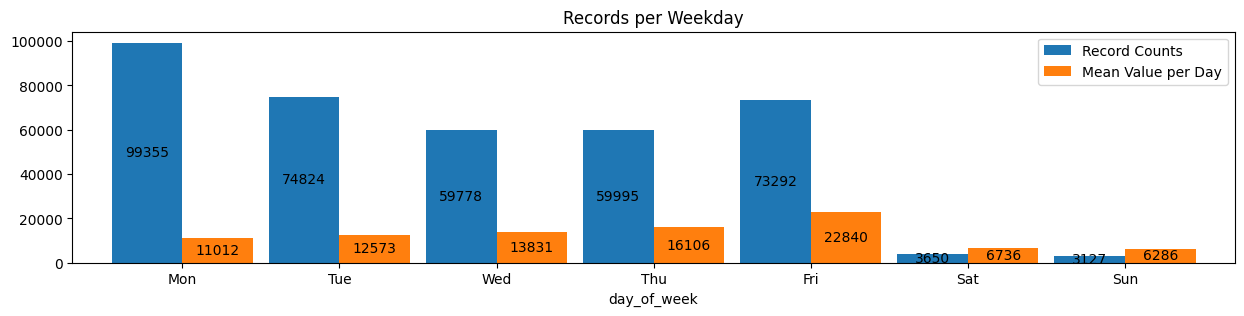

In [4]:
wd_mean_vals = df.reset_index().groupby('day_of_week').value.mean().astype(float).round(0)
wd_totals = df.reset_index().groupby('day_of_week').day_of_week.value_counts()
wd = pd.DataFrame({'Record Counts': wd_totals,
                   'Mean Value per Day': wd_mean_vals})
wd.index = wd.index.map(
    {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}.get
)
ax = wd.plot.bar(rot=0,
                 title='Records per Weekday',
                 figsize=(figure_width,3),
                 width=.9)
for cont in ax.containers:
    ax.bar_label(cont, label_type='center')
# ax.get_figure().savefig(fig_path+'deposits_per_weekday.png', bbox_inches='tight')

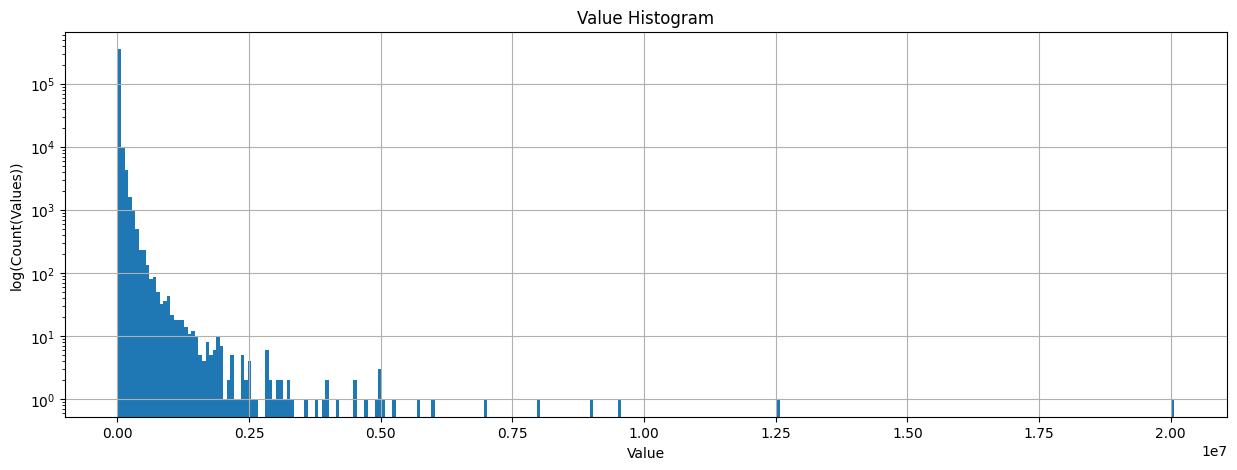

In [5]:
n_bins = 3 * (10**2)
plt.title(f"Value Histogram")
plt.xlabel("Value")
plt.ylabel("log(Count(Values))")
ax = df.value.hist(bins=n_bins, figsize=(figure_width,5), log=True)
min_ylim, max_ylim = plt.ylim()

Text(7.9835273799821485, 8540.565760851316, 'Mean Seq Length: 7.3')

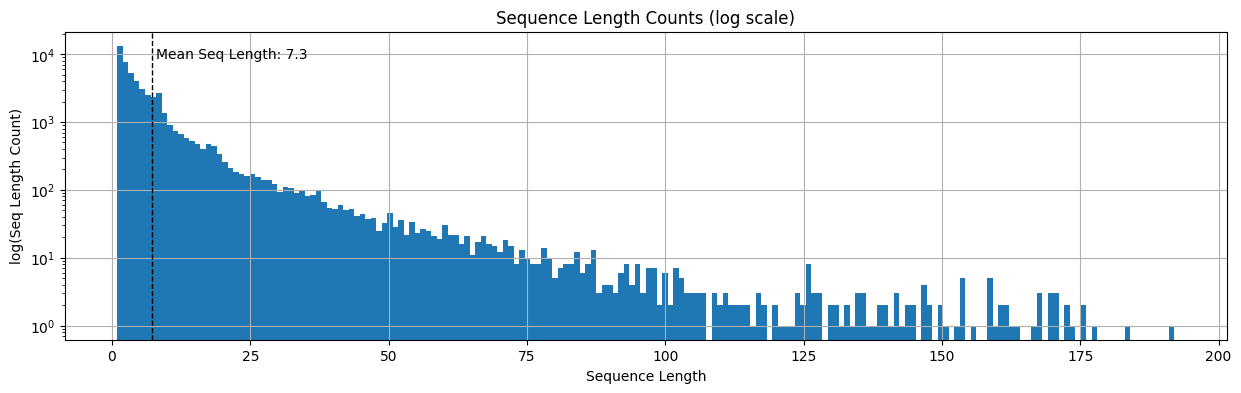

In [6]:
seq_lens = df.reset_index().seq_guid.value_counts()
plt.title('Sequence Length Counts (log scale)')
plt.xlabel('Sequence Length')
plt.ylabel('log(Seq Length Count)')
ax = seq_lens.hist(bins=seq_lens.max(), figsize=(figure_width,4), log=True)
plt.axvline(seq_lens.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(seq_lens.mean()*1.1,
         max_ylim*0.4,
         'Mean Seq Length: {:.1f}'.format(seq_lens.mean()))

In [7]:
# does sequence length correlate with value?
df['seq_len'] = pd.Series(dtype='Int64')
for idx, length in seq_lens.items():
    df.loc[idx, 'seq_len'] = int(length)
(df.reset_index()
   .drop(['seq_guid','timestamp','fed_holiday','date','day_of_week', 'weekend'], axis=1)
   .corr())

,value,seq_len
value,1.000000,-0.033175
seq_len,-0.033175,1.000000


In [8]:
from scipy import stats

In [9]:
# Does value correlate with federal holidays?
stats.pointbiserialr(df.fed_holiday, df.value)

SignificanceResult(statistic=-0.0026632675378060865, pvalue=0.10335985434413816)

In [10]:
# Does value correlate with weekend status?
stats.pointbiserialr(df.weekend, df.value)

SignificanceResult(statistic=-0.01350420905819089, pvalue=1.46710136076503e-16)